In [83]:
import numpy as np
import os
import re
import seaborn as sns

from tqdm.notebook import tqdm

In [41]:
# Load the data
data_dir = "data/AAMAS"
dset_idx = 1
which_dset = "00037-0000000%d.cat" % dset_idx

dset_sizes = [(201, 613), (161, 442), (667, 526)]
# Yes, maybe, no answer, no
rating_scores = [1.0, .5, -1.0, 0.0]

if dset_idx == 3:
    # Yes, maybe, no, conflict
    rating_scores = [1.0, .5, 0.0, 0.0]

agent_idx = 0
with open(os.path.join(data_dir, which_dset)) as f:
    ratings = np.ones(dset_sizes[dset_idx-1])*-1
    for l in f.readlines():
        if not l.startswith("#"):
            l = re.sub("[0-9]*:", "", l)
            bracket_list = re.compile("\{[0-9,]*\}|[0-9]+")
            lists = bracket_list.findall(l)
            if len(lists) != 4:
                print("PROBLEM")
            for idx, list_of_prefs in enumerate(lists):
                if list_of_prefs != '{}':
                    list_of_prefs = re.sub("[\{\}]", "", list_of_prefs)
                    prefs = [int(x)-1 for x in list_of_prefs.split(",")]
                    ratings[agent_idx, prefs] = rating_scores[idx]
            agent_idx += 1

<Axes: ylabel='Count'>

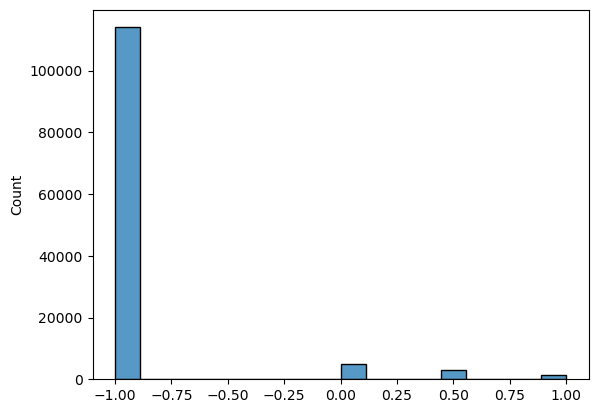

In [43]:
sns.histplot(ratings.flatten())

In [145]:
# Use https://dl.acm.org/doi/pdf/10.1145/1553374.1553452 to get prob model for CVaR objectives
gen = np.random.default_rng(seed=0)
q = 20
x = gen.normal(loc=0, scale=1e-3, size=(ratings.shape[0], q))
sig = .05

In [146]:
x

array([[ 0.00012573, -0.0001321 ,  0.00064042, ..., -0.0003163 ,
         0.00041163,  0.00104251],
       [-0.00012853,  0.00136646, -0.00066519, ..., -0.00012961,
         0.00078398,  0.00149343],
       [-0.00125907,  0.00151392,  0.00134588, ...,  0.00069604,
        -0.00118412, -0.0006617 ],
       ...,
       [-0.00122025,  0.00180565, -0.0008769 , ..., -0.00079379,
         0.00104554,  0.00124014],
       [-0.00090172,  0.00200668,  0.00164781, ...,  0.0005503 ,
         0.00055105, -0.00087052],
       [ 0.00085203,  0.00032889, -0.00011686, ..., -0.00071641,
        -0.00065821, -0.00013153]])

In [147]:
gen.integers(0, 5)

0

In [148]:
n_iter = 100

lr = 1e-4

for i in tqdm(range(n_iter)):
#     item_idx = gen.integers(ratings.shape[1])
    for item_idx in range(ratings.shape[1]):
        # pick out the users where this item was rated
        observed = np.where(ratings[:, item_idx] > -1)[0]
#         print(observed)
#         print(x[observed])
        if len(observed):
            Cj = np.matmul(x[observed], x[observed].T) + (sig**2)*np.eye(len(observed))
#             print(Cj)
            Cinv = np.linalg.inv(Cj)
            yobs = ratings[observed, item_idx]
    #         print(yobs)
            G = np.outer(yobs, yobs)
            G = np.matmul(Cinv, G)
            G = np.matmul(G, Cinv)
            G -= Cinv
            grad = np.matmul(-G, x[observed])

            x[observed] -= lr*grad

  0%|          | 0/100 [00:00<?, ?it/s]

In [149]:
x

array([[-0.04946097, -0.00744492,  0.07364609, ..., -0.080177  ,
         0.02572204,  0.04857842],
       [ 0.06778936, -0.01581532, -0.01815074, ..., -0.05820671,
        -0.14696196, -0.01128624],
       [-0.08633284, -0.1021693 ,  0.20555517, ..., -0.04690341,
         0.12974979, -0.01919305],
       ...,
       [ 0.08806593,  0.04613751,  0.07014316, ..., -0.06234164,
         0.01073899, -0.00353437],
       [-0.01719958, -0.00211378,  0.03450988, ..., -0.01258759,
        -0.01976353, -0.01044792],
       [-0.08393548, -0.14142617,  0.15081523, ..., -0.13087808,
         0.16324462, -0.14224183]])

In [150]:
# For each item, we can sample the rating for each user. It is by section 3.1, the prediction of user rating section.
print(x.shape)
k = np.matmul(x, x.T)
s = k + (sig**2)*np.eye(k.shape[0])
mu_matrix = np.zeros(ratings.shape)
zeta_matrix = np.zeros(ratings.shape)
for item_idx in tqdm(range(ratings.shape[1])):
    for user_idx in range(ratings.shape[0]):
        observed = np.where(ratings[:, item_idx] > -1)[0]
        sobs = s[observed, :][:, observed]
        final_s = np.matmul(np.linalg.inv(sobs), k[observed, user_idx])
        mu = np.dot(final_s, ratings[observed, item_idx])
        mu_matrix[user_idx, item_idx] = mu
        zeta_matrix[user_idx, item_idx] = k[user_idx, user_idx] + sig**2 - np.dot(k[observed, user_idx], final_s)
        
# cov_mat = np.matmul(x, x.T) + (sig**2)*np.eye(x.shape[0])
# zero_vec = np.zeros(x.shape[0])

(201, 20)


  0%|          | 0/613 [00:00<?, ?it/s]

In [151]:
ratings[np.where(ratings > .5)]

array([1., 1., 1., ..., 1., 1., 1.])

In [155]:
mu_matrix[np.where(ratings == -1)][:30]

array([-0.01621861,  0.28169282,  0.23701582,  0.10838368, -0.2615885 ,
        0.47669638,  0.04270126,  0.13154674,  0.46009273,  0.01434247,
        0.33669058, -0.27595985,  0.        ,  0.2385581 ,  0.12300941,
        0.04526598, -0.1431527 ,  0.        ,  0.33957263,  0.44809244,
        0.03617239,  0.        , -0.05069996, -0.17888261,  0.        ,
        0.15625124, -0.05879681,  0.44051402,  0.07920854,  0.09037884])

<Axes: ylabel='Count'>

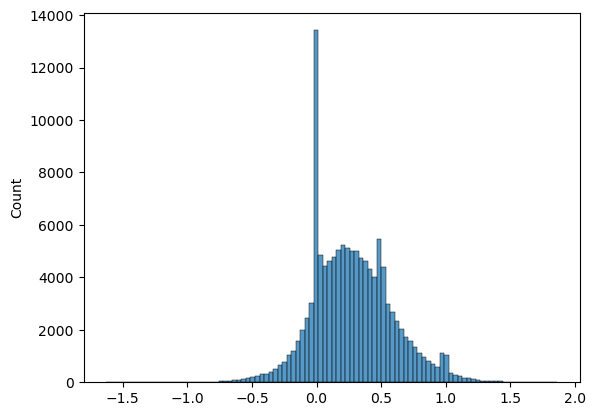

In [156]:
sns.histplot(mu_matrix.flatten(), bins=100)

<Axes: ylabel='Count'>

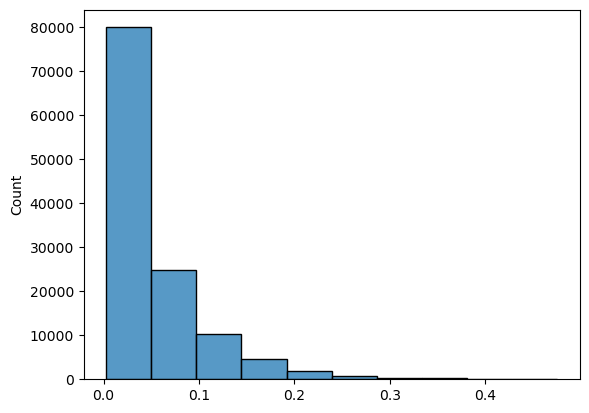

In [157]:
sns.histplot(zeta_matrix.flatten(), bins=10)

In [158]:
np.max(zeta_matrix, axis=0)

array([0.15194241, 0.13859594, 0.0507062 , 0.05612834, 0.32793219,
       0.04765433, 0.02811136, 0.34508156, 0.02078981, 0.12536627,
       0.08233812, 0.11086097, 0.02492427, 0.40562618, 0.03469057,
       0.13182147, 0.06501704, 0.32989277, 0.37585181, 0.45118057,
       0.22111023, 0.28826735, 0.41227688, 0.24847342, 0.05732374,
       0.01612703, 0.32669186, 0.47255597, 0.25802966, 0.04108789,
       0.06612102, 0.32190418, 0.32934102, 0.15792025, 0.28214656,
       0.37641849, 0.124527  , 0.0728178 , 0.18503687, 0.05196345,
       0.17868831, 0.1262745 , 0.10693518, 0.10158686, 0.1138225 ,
       0.36022514, 0.34831542, 0.24278315, 0.28024291, 0.02818292,
       0.04031584, 0.06534489, 0.10100747, 0.05640988, 0.05800738,
       0.37379741, 0.2526848 , 0.06971938, 0.0467932 , 0.11262895,
       0.08524228, 0.31336816, 0.1884608 , 0.22299948, 0.0461245 ,
       0.07105353, 0.17999654, 0.06119408, 0.0172835 , 0.28160619,
       0.162687  , 0.06154334, 0.1075831 , 0.10365915, 0.04404

In [ ]:
# Use CV to get error bounds for adv robustness... or just take a CI of the Gaussian.